In [29]:
import torch
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm.notebook as tqdm

In [30]:
transform = transforms.ToTensor()

In [31]:
train_df = MNIST(root = '/data', download = True, transform = transform)

In [32]:
test_df = MNIST(root='/data', train=False, transform = transform)

In [33]:
batch_size = 128
train_dl = DataLoader(train_df, batch_size = batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_dl = DataLoader(test_df, batch_size = batch_size, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [34]:
def images_grid(dataloader):
  for batch in dataloader:
    images, _ = batch
    plt.figure(figsize=(9,6))
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    plt.axis('off')
    break

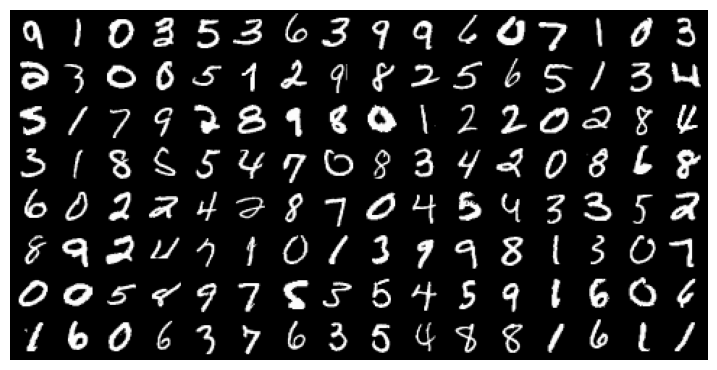

In [35]:
images_grid(train_dl)

In [36]:
class VAE_Linear(nn.Module):
  def __init__(self,input_dim=784, latent_dim=2):
    super(VAE_Linear, self).__init__()
    self.encoder = nn.Sequential(
                                nn.Linear(input_dim, 512),
                                nn.ReLU(),
                                nn.Linear(512, 256),
                                nn.ReLU(),
                                nn.Linear(256, 128)
    )
    self.mu = nn.Linear(128, latent_dim)
    self.sigma = nn.Linear(128,latent_dim)

    self.decoder = nn.Sequential(
                                  nn.Linear(2,128),
                                  nn.ReLU(),
                                  nn.Linear(128,256),
                                  nn.ReLU(),
                                  nn.Linear(256,512),
                                  nn.ReLU(),
                                  nn.Linear(512,784),
                                  nn.Sigmoid()
    )

  def encodings_generator(self,mu,sigma):
    eps = torch.randn_like(sigma)
    x = torch.exp(0.5 * sigma)
    return (x * eps) + mu

  def forward(self, x):
    encodings_1 = self.encoder(x)
    mu = self.mu(encodings_1)
    sigma = self.sigma(encodings_1)
    encodings = self.encodings_generator(mu,sigma)
    decodings = self.decoder(encodings)
    return mu, sigma, encodings, decodings


In [37]:
model = VAE_Linear()
model

VAE_Linear(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (mu): Linear(in_features=128, out_features=2, bias=True)
  (sigma): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [38]:
def loss_func(mu, sigma):
  kld = 1 + sigma - torch.square(mu) - torch.exp(sigma)
  kld = -0.5 * torch.sum(kld)
  return kld
def loss_func2(outputs, inputs, mu, sigma):
  # loss = F.binary_cross_entropy(outputs, inputs)
  loss = F.mse_loss(outputs, inputs)
  kld = 1 + sigma - torch.square(mu) - torch.exp(sigma)
  kld = -0.5 * torch.sum(kld)
  return kld, loss

In [39]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
device = get_default_device()
print(f"default device is >>> {device}")
model = to_device(model, device)
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

default device is >>> cuda


In [41]:
def fit(lr, num_epochs, model=model, train_dl=train_dl, loss_function=loss_func2, optim_func = torch.optim.Adam):
  print('Starting Optimization.....')
  optimizer = optim_func(model.parameters(), lr)
  train_losses = []
  outputs = []
  print('Starting Epochs.....')
  for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_dl:
      images, _ = batch
      images = images.reshape(-1,784)
      mu, sigma, encodings, decodings = model(images)
      loss_tuple = loss_function(decodings,images,mu, sigma)
      kld, bce_loss = loss_tuple
      loss = kld + bce_loss
      # loss = kld
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss
    epoch_loss /= len(train_dl)
    train_losses.append(epoch_loss)
    outputs.append((epoch,images, encodings, decodings,mu, sigma))
    print(f'epoch : {epoch+1}, loss : {epoch_loss:.4f}')
  return outputs, train_losses

In [44]:
num_epochs = 10
lr = 1e-3
output_list, train_losses = fit(lr, num_epochs)

Starting Optimization.....
Starting Epochs.....
epoch : 1, loss : 0.0675
epoch : 2, loss : 0.0673
epoch : 3, loss : 0.0673
epoch : 4, loss : 0.0673
epoch : 5, loss : 0.0673
epoch : 6, loss : 0.0673
epoch : 7, loss : 0.0673
epoch : 8, loss : 0.0673
epoch : 9, loss : 0.0673
epoch : 10, loss : 0.0673


In [50]:
train_loss = []
for i in train_losses:
  i = i.detach().cpu().clone()
  train_loss.append(i)


Text(0.5, 1.0, 'Train Losses VS Epochs')

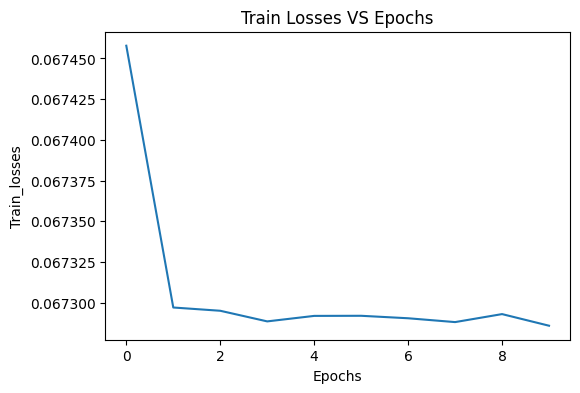

In [51]:
plt.figure(figsize=(6,4))
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Train_losses')
plt.title('Train Losses VS Epochs')

In [63]:
def show_images(output_list, index_1,index_2):
  if index_2 == 2:
    imgs = output_list[index_1][index_2].cpu().detach().numpy()
    print(f'output shape is>>> {imgs.shape}')
    imgs=imgs.reshape(-1,1,1)
    print(f'reshaped output shape is>>> {imgs.shape}')
    plt.figure(figsize=(9,3))
    for i in range(1,28):
      plt.subplot(3, 9, i)
      plt.imshow(imgs[i - 1])
      i +=1
  else:
    imgs = output_list[index_1][index_2].cpu().detach().numpy()
    print(f'output shape is>>> {imgs.shape}')
    imgs=imgs.reshape(-1,28,28)
    print(f'reshaped output shape is>>> {imgs.shape}')
    plt.figure(figsize=(9,3))
    for i in range(1,28):
      plt.subplot(3, 9, i)
      plt.imshow(imgs[i - 1])
      i +=1

output shape is>>> (96, 784)
reshaped output shape is>>> (96, 28, 28)


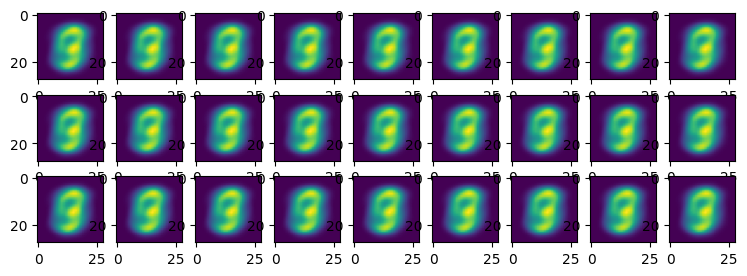

In [64]:
show_images(output_list, 9, 3)

output shape is>>> (96, 2)
reshaped output shape is>>> (192, 1, 1)


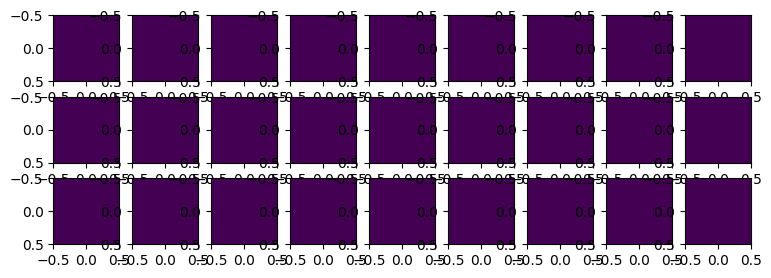

In [65]:
show_images(output_list, 9, 2)